In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [26]:
# PARAMETERS
INPUT_HEIGHT = 128
INPUT_WIDTH = 128

INPUT_SHAPE = (INPUT_HEIGHT, INPUT_WIDTH, 1)

latent_dims = 32



In [27]:
class Preprocessor(tf.keras.Model):
  def __init__(self):
    super().__init__(name="preprocessor")
    self.resizer = tf.keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH, name=f"{self.name}_resizer")
    self.rescaler = tf.keras.layers.Rescaling(scale=1./255, name=f"{self.name}_rescaler")

  def call(self, inputs):
    return self.rescaler(
        self.resizer(inputs)
    )

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization

In [28]:


class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dims):
    super().__init__(name="encoder")

    self.latent_dims = latent_dims

    # layers
    self.preprocess = Preprocessor()
    # 128 x 128 x 1
    self.conv1 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv1')
    self.bnorm1 = BatchNormalization(name="encoder_bnorm1")
    self.mpool1 = MaxPool2D(name='encoder_mpool1')

    # 64 x 64 x 128
    self.conv2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv2')
    self.bnorm2 = BatchNormalization(name="encoder_bnorm2")
    self.mpool2 = MaxPool2D(name='encoder_mpool2')

    # 32 x 32 x 64
    self.conv3 = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv3')
    self.bnorm3 = BatchNormalization(name="encoder_bnorm3")
    self.mpool3 = MaxPool2D(name='encoder_mpool3')

    # 16 x 16 x 32
    self.conv4 = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', name='encoder_conv4')
    self.bnorm4 = BatchNormalization(name="encoder_bnorm4")
    self.mpool4 = MaxPool2D(name='encoder_mpool4')

    # 8 x 8 x 16
    self.flatten = Flatten(name='encoder_flatten')

    self.dense1 = Dense(2 * self.latent_dims, name='encoder_dense1')
    # 2 x self.latent_dims


    self.logvar = Dense(self.latent_dims, name='encoder_logvar')
    self.mu = Dense(self.latent_dims, name='encoder_mu')
    self.sigma = Lambda(lambda x: tf.exp(0.5*x), name='encoder_sigma')

  def encode(self, inputs, preprocess=True):
    # print the shape of the input
    # print(f"Shape of input to encoder: {inputs.shape}")
    p = self.preprocess(inputs) if preprocess else inputs
    x=self.conv1(p); x=self.bnorm1(x); x=self.mpool1(x)
    x=self.conv2(x); x=self.bnorm2(x);  x=self.mpool2(x)
    x=self.conv3(x); x=self.bnorm3(x);  x=self.mpool3(x)
    x=self.conv4(x); x=self.bnorm4(x);  x=self.mpool4(x)
    x=self.flatten(x)
    x=self.dense1(x)
    # print(f"Shape of output from encoder: {x.shape}")

    return self.mu(x), self.logvar(x), self.sigma(self.logvar(x)), p


  def call(self, inputs):
    return self.encode(inputs)

  def summary(self, input_shape):
    x = tf.keras.layers.Input(shape=input_shape)
    model = tf.keras.Model(inputs=[x], outputs=self.call(x))
    return model.summary()


In [31]:
class Decoder(tf.keras.Model):
    def __init__(self, latent_dims):
        super().__init__(name='decoder')

        self.latent_dims = latent_dims

        # layers
        self.dense1 = Dense(8 * 8 * 16, activation='relu', name='decoder_dense1')
        self.reshape1 = Reshape((8, 8, 16), name='decoder_reshape1')

        # 8 x 8 x 16 -> 16 x 16 x 32
        self.convT1 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT1')
        self.bnorm1 = BatchNormalization(name="decoder_bnorm1")

        # 16 x 16 x 32 -> 32 x 32 x 64
        self.convT2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT2')
        self.bnorm2 = BatchNormalization(name="decoder_bnorm2")

        # 32 x 32 x 64 -> 64 x 64 x 128
        self.convT3 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='decoder_convT3')
        self.bnorm3 = BatchNormalization(name="decoder_bnorm3")

        # 64 x 64 x 128 -> 128 x 128 x 1
        self.output_layer = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid', name='decoder_output')

    def decode(self, z):
        x = self.dense1(z)
        x = self.reshape1(x)

        x = self.convT1(x)
        x = self.bnorm1(x)

        x = self.convT2(x)
        x = self.bnorm2(x)

        x = self.convT3(x)
        x = self.bnorm3(x)

        return self.output_layer(x)

    def call(self, inputs):
        return self.decode(inputs)

    def summary(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()


In [32]:
encoder = Encoder(latent_dims=latent_dims) # Example latent_dims
print("Encoder Summary:")
encoder.summary(input_shape=INPUT_SHAPE)

decoder = Decoder(latent_dims=latent_dims)
print("\nDecoder Summary:")
decoder.summary(input_shape=(latent_dims,))

Encoder Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ preprocessor              │ (None, 128, 128, 1)    │              0 │ input_layer_6[0][0]    │
│ (Preprocessor)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv1 (Conv2D)    │ (None, 128, 128, 128)  │          1,280 │ preprocessor[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm1            │ (None, 128, 128, 128)  │            512 │ encoder_conv1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool1            │ (None, 64, 64, 128)    │              0 │ encoder_bnorm1[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv2 (Conv2D)    │ (None, 64, 64, 64)     │         73,792 │ encoder_mpool1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm2            │ (None, 64, 64, 64)     │            256 │ encoder_conv2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool2            │ (None, 32, 32, 64)     │              0 │ encoder_bnorm2[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv3 (Conv2D)    │ (None, 32, 32, 32)     │         18,464 │ encoder_mpool2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm3            │ (None, 32, 32, 32)     │            128 │ encoder_conv3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool3            │ (None, 16, 16, 32)     │              0 │ encoder_bnorm3[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv4 (Conv2D)    │ (None, 16, 16, 16)     │          4,624 │ encoder_mpool3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_bnorm4            │ (None, 16, 16, 16)     │             64 │ encoder_conv4[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_mpool4            │ (None, 8, 8, 16)       │              0 │ encoder_bnorm4[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_flatten (Flat

 Total params: 168,880 (659.69 KB)

 Trainable params: 168,400 (657.81 KB)

 Non-trainable params: 480 (1.88 KB)


Decoder Summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense1 (Dense)               │ (None, 1024)                │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_reshape1 (Reshape)           │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT1 (Conv2DTranspose)     │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm1 (BatchNormalization)  │ (None, 16, 16, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT2 (Conv2DTranspose)     │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm2 (BatchNormalization)  │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convT3 (Conv2DTranspose)     │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bnorm3 (BatchNormalization)  │ (None, 64, 64, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 128, 128, 1)         │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,833 (518.88 KB)

 Trainable params: 132,385 (517.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
class ReconstructionLoss(tf.keras.layers.Layer):
  def __init__(self):
    super(ReconstructionLoss, self).__init__(name="reconstruction_loss")

  def call(self, inputs):
    x = inputs[0]
    recon_x = inputs[1]

    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x), axis=[1,2])
    recon_loss = tf.reduce_mean(recon_loss)

    self.add_loss(recon_loss)

    return recon_loss

In [34]:
class KLLoss(tf.keras.layers.Layer):
  def __init__(self, beta=3.0):
    super(KLLoss, self).__init__()

    self.beta = beta

  def call(self, inputs):
    mu = inputs[0]
    logvar = inputs[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=1)
    kl_loss = kl_loss * self.beta

    self.add_loss(kl_loss)
    return kl_loss

In [35]:
# Sampler

class Sampler(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="sampler")

  def call(self, inputs):
    mu = inputs[0]
    sigma = inputs[1]

    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))

    # reparameterize
    output =  mu + tf.multiply(sigma, epsilon)

    # print(f"Shape of output from sampler: {output.shape}")
    return output



In [36]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dims):
    super().__init__(name="bvae")

    self.latent_dims = latent_dims

    # layers
    self.encoder = Encoder(self.latent_dims)
    self.decoder = Decoder(self.latent_dims)

    self.sampler = Sampler()

    self.reconstruction_loss = ReconstructionLoss()
    self.kl_loss = KLLoss(beta=4.0)

    # trackers
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

  def get_config(self):
    config = super().get_config()
    config.update({
        "latent_dims": self.latent_dims,
    })
    return config

  @classmethod
  def from_config(cls, config):
    # Extract latent_dims from the config
      latent_dims = config.pop('latent_dims')
      # Remove other keys added by Keras during saving if they are not needed for __init__
      config.pop('name', None)
      config.pop('trainable', None)
      config.pop('dtype', None)
      # Create an instance of the class using the extracted latent_dims
      return cls(latent_dims=latent_dims, **config)



  def call(self, inputs):
    mu, logvar, sigma, x = self.encoder(inputs)
    z = self.sampler([mu, sigma])
    # print(f"Shape of z: {z.shape}")
    recon_x = self.decoder(z)

    kl_loss = self.kl_loss([mu, logvar])
    reconstruction_loss = self.reconstruction_loss([x, recon_x])

    return recon_x, kl_loss, reconstruction_loss

  @property
  def metrics(self):
      return [
          self.loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def train_step(self, data):
    # print(f"Shape of input data in train_step: {data.shape}")

    with tf.GradientTape() as tape:
      recon_x, kl_loss, reconstruction_loss = self(data)
      total_loss = reconstruction_loss + kl_loss

      # update the trackers
      self.loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)

      # gradients
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        m.name: m.result() for m in self.metrics
    }

  def test_step(self, data):
    recon_x, kl_loss, reconstruction_loss = self(data)
    total_loss = reconstruction_loss + kl_loss
    self.loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        m.name: m.result() for m in self.metrics
    }

  def encode(self, inputs, preprocess=True):
    return self.encoder.encode(inputs, preprocess=preprocess)

  def decode(self, inputs):
    return self.decoder.decode(inputs)

  def sample(self, mu, sigma):
    return self.sampler([mu, sigma])

  def calculate_reconstruction_loss(self, inputs):
    return self.reconstruction_loss(inputs)

  def calculate_kl_loss(self, inputs):
    return self.kl_loss(inputs)






In [37]:
class BetaVaeParameterUpdater(tf.keras.callbacks.Callback):
  def __init__(self, delta, limit):
    super().__init__()
    self.delta = delta
    self.limit = limit

  @tf.function
  def update_beta(self):
    beta = self.model.kl_loss.beta
    beta = tf.math.maximum(beta - self.delta, self.limit)

  def on_epoch_end(self, epoch, logs=None):
    self.update_beta()

In [38]:
images_path = "/kaggle/input/image-data/images"

In [39]:
model = BVAE(latent_dims=latent_dims)
print("latent_dims:", latent_dims)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))



latent_dims: 32


In [40]:
dummy_input = tf.zeros((1, INPUT_HEIGHT, INPUT_WIDTH, 1))
model(dummy_input)
model.summary()


Model: "bvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │         168,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         132,833 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampler (Sampler)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstruction_loss                  │ ?                           │               0 │
│ (ReconstructionLoss)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kl_loss_2 (KLLoss)                   │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,713 (1.15 MB)

 Trainable params: 300,785 (1.15 MB)

 Non-trainable params: 928 (3.62 KB)

In [41]:
images = tf.keras.utils.image_dataset_from_directory(
    images_path,
    labels=None,
    color_mode='grayscale',
    image_size=(128, 128),
    batch_size=16,
    shuffle=True, # Ensure shuffling for random split
    seed=42 # Optional: Set seed for reproducible split
)

# clamp the values using threshold and ivnert the color
images = images.map(lambda x:255 - tf.clip_by_value(x, 0, 255))



# Calculate the size of the dataset
dataset_size = tf.data.experimental.cardinality(images).numpy()

train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset using take and skip
train_ds = images.take(train_size)
test_ds = images.skip(train_size)

Found 1899 files.


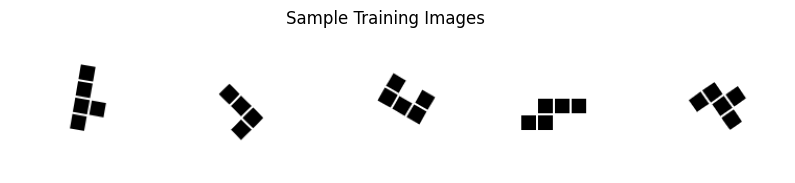

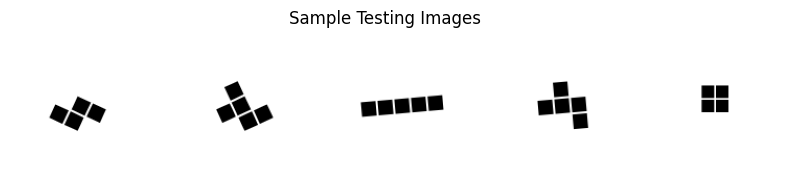

In [42]:
# prompt: plot part of the dataset

import matplotlib.pyplot as plt

# Take the first batch from the training dataset
for batch in train_ds.take(1):
    # The batch is a tensor of images
    images_batch = batch

# Select a few images from the batch to plot
num_images_to_plot = 5
plt.figure(figsize=(10, 2))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    # Squeeze to remove the channel dimension for grayscale images if needed for plotting
    plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Training Images')
plt.show()

# Take the first batch from the testing dataset
for batch in test_ds.take(1):
    # The batch is a tensor of images
    images_batch = batch

# Select a few images from the batch to plot
plt.figure(figsize=(10, 2))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    # Squeeze to remove the channel dimension for grayscale images if needed for plotting
    plt.imshow(tf.squeeze(images_batch[i]).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Testing Images')
plt.show()


Epoch 1/1000


I0000 00:00:1750198329.378372      96 service.cc:148] XLA service 0x7d93ec002ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750198329.379358      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 8/95 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 2586.9824 - loss: 14544.3857 - reconstruction_loss: 11957.4043

I0000 00:00:1750198334.957810      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - kl_loss: 688.7249 - loss: 9710.3799 - reconstruction_loss: 9021.6562 - val_kl_loss: 258.5073 - val_loss: 2192.6501 - val_reconstruction_loss: 1935.3461
Epoch 2/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 210.4119 - loss: 1753.3550 - reconstruction_loss: 1542.9432 - val_kl_loss: 192.5318 - val_loss: 1163.7965 - val_reconstruction_loss: 973.4751
Epoch 3/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 193.3324 - loss: 1092.9089 - reconstruction_loss: 899.5765 - val_kl_loss: 185.4097 - val_loss: 907.8425 - val_reconstruction_loss: 723.0860
Epoch 4/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 182.8367 - loss: 871.0656 - reconstruction_loss: 688.2290 - val_kl_loss: 181.9435 - val_loss: 823.6266 - val_reconstruction_loss: 642.8050
Epoch 5/1000
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 183.7613 - loss: 781.8188 - reconstruction_loss: 598.0576 - val_kl_loss: 193.4129 - val_loss: 783.6519 - val_reconstruction_loss

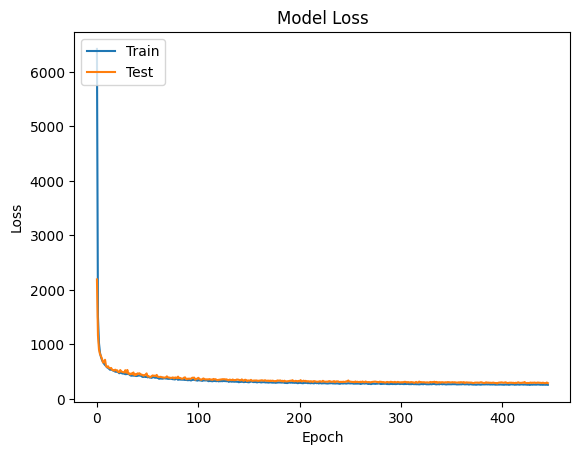

In [43]:
import matplotlib.pyplot as plt

beta_updater_callback = BetaVaeParameterUpdater(delta=2e-4, limit=0.0) # Example values

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     patience=50,
                                                     cooldown=25,
                                                     min_lr=1e-5,
                                                     min_delta=1.0,
                                                     verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=50,
                                                           restore_best_weights=True,
                                                           min_delta=1.0,
                                                           verbose=1)
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(
    train_ds,
    epochs=1000, # Adjust the number of epochs as needed
    validation_data=test_ds,
    callbacks=[beta_updater_callback, early_stop_callback] # Add the callback
)

# Plot training history (optional)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
loaded_model_path = "/kaggle/input/polyomino_32/keras/default/1/bvae_model_ldims_32.keras"
loaded_model = tf.keras.models.load_model(loaded_model_path, custom_objects={'BVAE':BVAE})

In [21]:
loaded_model.summary()

Model: "bvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │         168,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         135,217 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampler (Sampler)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstruction_loss                  │ ?                           │               0 │
│ (ReconstructionLoss)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kl_loss_1 (KLLoss)                   │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 910,373 (3.47 MB)

 Trainable params: 303,137 (1.16 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 606,276 (2.31 MB)

In [51]:
# save the model
model.save(f"bvae_model_ldims_{latent_dims}_new.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


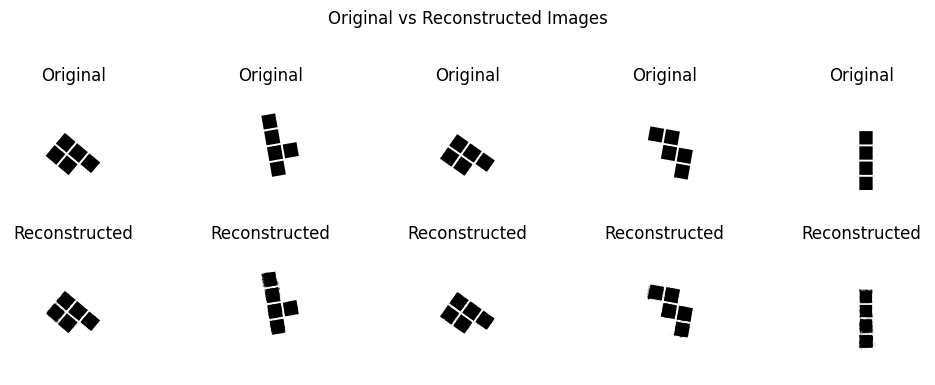

In [45]:
import matplotlib.pyplot as plt
# Select a few images from the test dataset to reconstruct
num_images_to_reconstruct = 5

# Take a batch from the test dataset
for test_batch in test_ds.take(1):
    # Select the first `num_images_to_reconstruct` images from the batch
    original_images = test_batch[:num_images_to_reconstruct]

# Get the reconstructed images from the model
# Ensure the model is built by passing a sample input
model.predict(original_images[:1])
reconstructed_images, _, _ = model(original_images)


# Plot the original and reconstructed images side by side
plt.figure(figsize=(10, 4))
for i in range(num_images_to_reconstruct):
    # Plot original image
    plt.subplot(2, num_images_to_reconstruct, i + 1)
    plt.imshow(tf.squeeze(original_images[i]).numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(2, num_images_to_reconstruct, i + 1 + num_images_to_reconstruct)
    plt.imshow(tf.squeeze(reconstructed_images[i]).numpy(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle('Original vs Reconstructed Images')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap of title
plt.show()

In [22]:
import matplotlib.pyplot as plt
# Select a few images from the test dataset to reconstruct
num_images_to_reconstruct = 1

# Take a batch from the test dataset
for test_batch in test_ds.take(1):
    # Select the first `num_images_to_reconstruct` images from the batch
    to_encode_images = test_batch[:num_images_to_reconstruct]
to_encode_images

<tf.Tensor: shape=(1, 128, 128, 1), dtype=float32, numpy=
array([[[[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        ...,

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]],

        [[255.],
         [255.],
         [255.],
         ...,
         [255.],
         [255.],
         [255.]]]], dtype=float32)>

In [24]:
encoded_images = loaded_model.encode(to_encode_images)
mu, log, sigma, recon = encoded_images

mu

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-1.55325711e+00, -1.36116087e+00, -6.17098361e-02,
        -1.82722712e+00,  3.78172994e-01, -3.83061320e-02,
        -7.16832757e-01,  2.39683747e-01,  2.89633870e-04,
         1.84583569e+00,  2.59885103e-01,  5.49875498e-01,
        -1.65768042e-02,  1.76278487e-01, -1.07626036e-01,
        -2.01029480e-01,  9.83111784e-02, -9.58694637e-01,
         3.62446427e-01,  1.73470452e-02, -1.99576998e+00,
        -1.62359858e+00, -1.69858858e-01,  9.32613909e-01,
        -2.16588467e-01, -2.54474849e-01,  1.01666346e-01,
         2.25841403e-01,  2.10761452e+00,  4.24415827e-01,
        -3.68829183e-02,  2.61937112e-01]], dtype=float32)>

Generating images by varying latent dimension 0


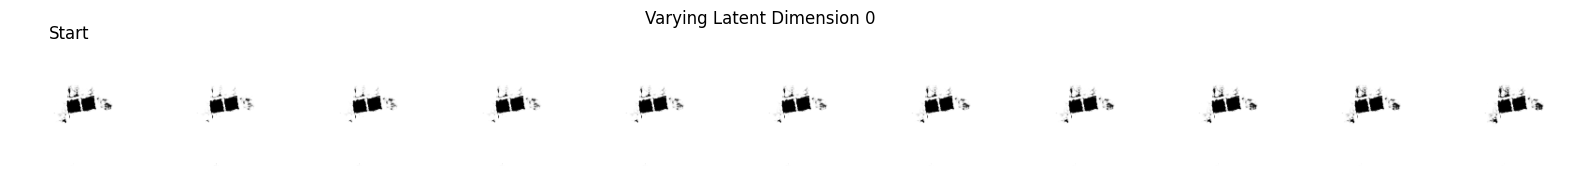

Generating images by varying latent dimension 1


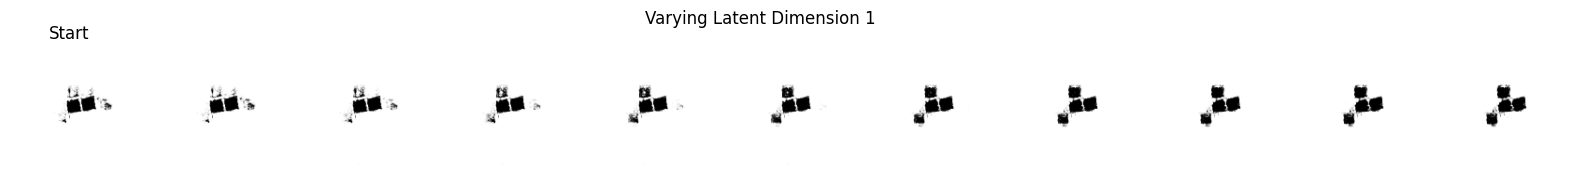

Generating images by varying latent dimension 2


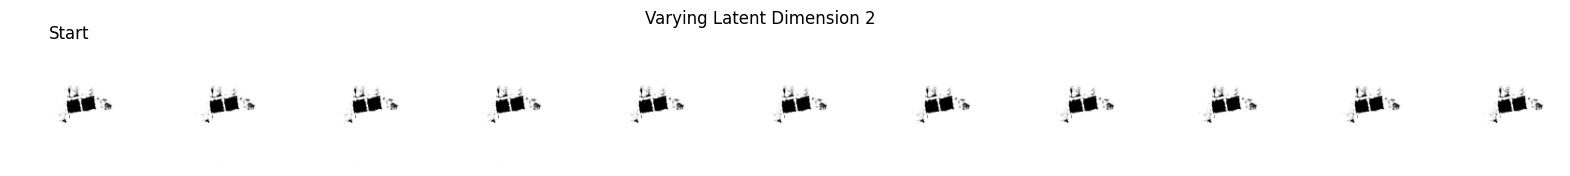

Generating images by varying latent dimension 3


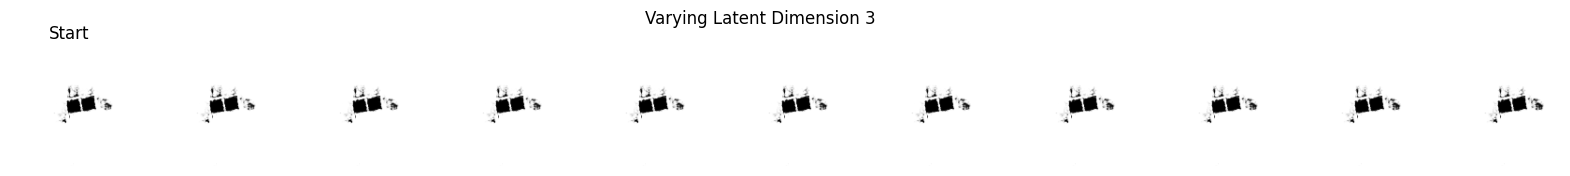

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def generate_images_along_latent(model, start_latent_vector, latent_dim_index, steps=10, span=3.0):
    images = []
    latent_values = np.linspace(-span, span, steps)

    for value in latent_values:
        current_latent_vector = np.copy(start_latent_vector)
        current_latent_vector[latent_dim_index] = value

        current_latent_vector_batch = np.expand_dims(current_latent_vector, axis=0)

        generated_image = model.decode(current_latent_vector_batch)
        generated_image = tf.squeeze(generated_image).numpy()

        images.append(generated_image)

    return images

latent_dims = model.latent_dims
random_latent_vector = np.random.normal(size=(latent_dims,))

start_image = model.decode(np.expand_dims(random_latent_vector, axis=0))
start_image = tf.squeeze(start_image).numpy()

for dim_index in range(min(latent_dims, 4)):
    print(f"Generating images by varying latent dimension {dim_index}")
    generated_images = generate_images_along_latent(
        model,
        random_latent_vector,
        dim_index,
        steps=10,
        span=1
    )

    plt.figure(figsize=(len(generated_images) * 2, 2))
    plt.subplot(1, len(generated_images) + 1, 1)
    plt.imshow(start_image, cmap='gray')
    plt.axis('off')
    plt.title('Start')

    for i, img in enumerate(generated_images):
        plt.subplot(1, len(generated_images) + 1, i + 2)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Varying Latent Dimension {dim_index}')
    plt.show()
